In [1]:
!kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset
License(s): CC0-1.0
 92% 137M/149M [00:01<00:00, 91.5MB/s]
100% 149M/149M [00:01<00:00, 88.7MB/s]


In [2]:
!unzip -q /content/the-iqothnccd-lung-cancer-dataset.zip

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 23.8 MB/s eta 0:00:00


In [4]:
import os
import random
import shutil
import cv2
import glob
import yaml
import matplotlib.pyplot as plt
import ultralytics
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
random.seed(2024)

In [6]:
data_root = '/content/The IQ-OTHNCCD lung cancer dataset'
file_root = f'{data_root}/data'
project_name = 'lung_cancer'

In [7]:
#정리할 디렉토리 정의
train_file_root = f'{data_root}/{project_name}'
train_root = f'{data_root}/{project_name}/train'
valid_root = f'{data_root}/{project_name}/valid'
test_root = f'{data_root}/{project_name}/test'

In [9]:
# Begin cases, Malignant cases, Normal cases 디렉토리를 data 디렉토리 안으로 넣어줌
cls_list = os.listdir(file_root)
cls_list

['Malignant cases', 'Bengin cases', 'Normal cases']

In [10]:
for folder in [train_root, valid_root, test_root]:
  if not os.path.exists(folder):
    os.makedirs(folder)
  for cls in cls_list:
    cls_folder = f'{folder}/{cls}'
    if not os.path.exists(cls_folder):
      os.makedirs(cls_folder)

In [11]:
for cls in cls_list:
  file_list = os.listdir(f'{file_root}/{cls}')
  random.shuffle(file_list)
  test_ratio = 0.1
  num_file = len(file_list)
  #print(num_file)
  test_list = file_list[:int(num_file*test_ratio)]
  valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
  train_list = file_list[int(num_file*test_ratio)*2:]
  #print(len(test_list), len(valid_list), len(train_list))
  for i in test_list:
    shutil.copyfile(f'{file_root}/{cls}/{i}', f'{test_root}/{cls}/{i}')
  for i in valid_list:
    shutil.copyfile(f'{file_root}/{cls}/{i}', f'{valid_root}/{cls}/{i}')
  for i in train_list:
    shutil.copyfile(f'{file_root}/{cls}/{i}', f'{train_root}/{cls}/{i}')

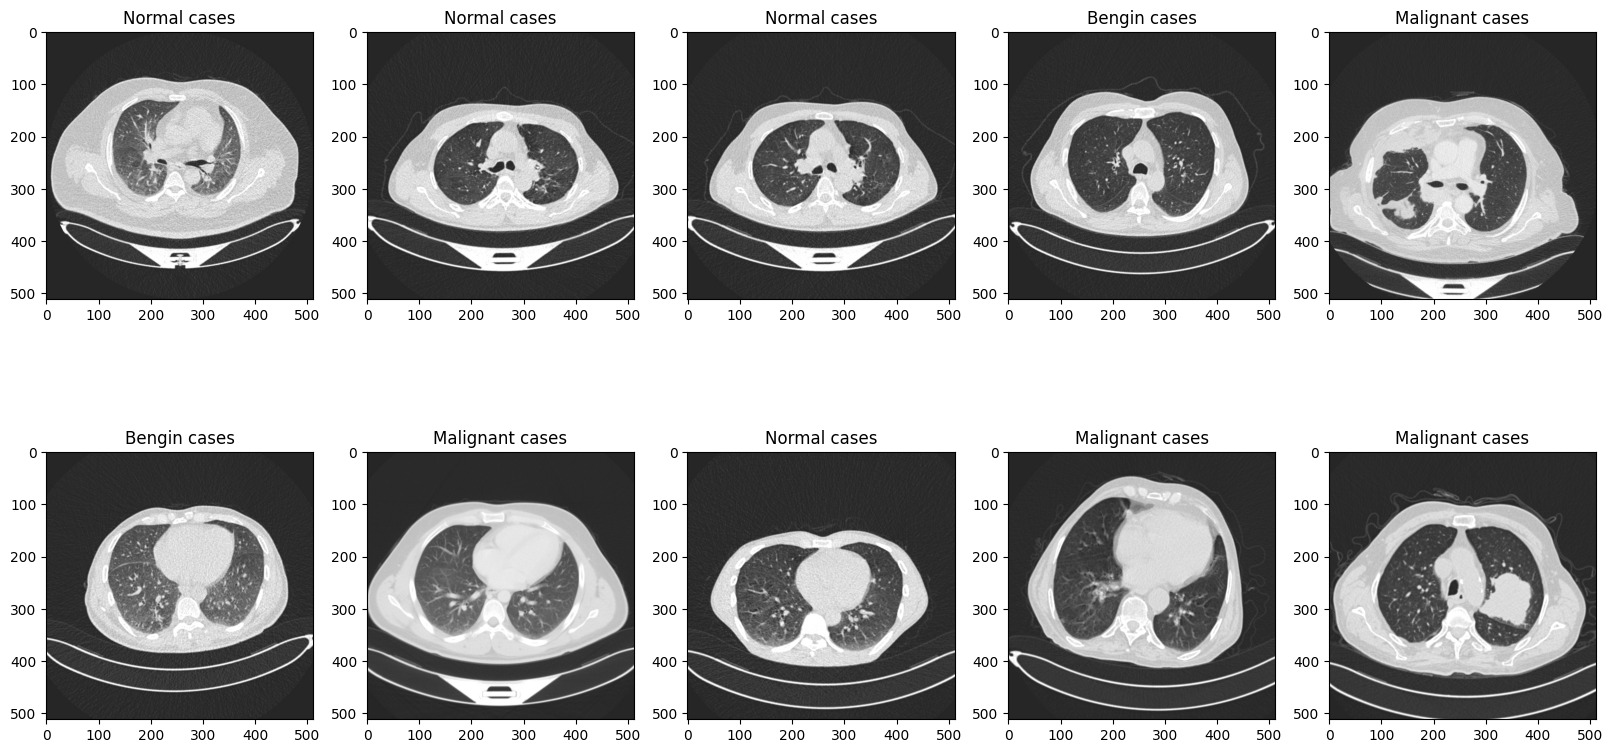

In [12]:
test_file_list = glob.glob(f'{test_root}/*/*')
random.shuffle(test_file_list)

plt.figure(figsize=(20, 10))
for i in range(10):
    test_img_path = os.path.join(test_root, test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')
    plt.subplot(2, 5, (i+1))
    # /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test/Bengin cases/Bengin case (10).jpg
    plt.title(test_file_list[i].split('/')[-2])
    plt.imshow(ori_img)

plt.show()

In [13]:
project_root = '/content/The IQ-OTHNCCD lung cancer dataset'

In [14]:
data = dict()
data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{project_root}/lung_cancer.yaml', 'w') as f:
  yaml.dump(data, f)

In [15]:
ultralytics.checks()

Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.6/112.6 GB disk)


In [16]:
%cd /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer

/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer


In [17]:
model = YOLO('yolov8s-cls.pt')

100%|██████████| 12.3M/12.3M [00:00<00:00, 45.0MB/s]


In [18]:
# patience: 조기종료(Early Stomping), 모델의 성능이 더이상 개선되지 않을 때 조기 종료를 수행하기 위한 기준
#예) patience=30 -> 성능이 개선되지 않는 에폭이 30번 이상 지속되면 학습을 조기 종료
results = model.train(data=f'{data_root}/{project_name}', epochs=50, batch=8, device=0, name='lung_cancer_s', patience=30)

Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer, epochs=50, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=lung_cancer_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅


train: Scanning /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train... 879 images, 0 corrupt: 100%|██████████| 879/879 [00:00<00:00, 3614.51it/s]

train: New cache created: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train.cache



val: Scanning /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test... 109 images, 0 corrupt: 100%|██████████| 109/109 [00:00<00:00, 4066.89it/s]

val: New cache created: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/lung_cancer_s
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50     0.346G      1.154          8        224:   6%|▋         | 7/110 [00:01<00:12,  8.32it/s]

       1/50     0.346G      1.129          8        224:  15%|█▌        | 17/110 [00:02<00:07, 12.14it/s]
100%|██████████| 755k/755k [00:00<00:00, 18.7MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.25it/s]

                   all      0.872          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 15.57it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  5.45it/s]

                   all      0.844          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 14.15it/s]

                   all      0.872          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.321G     0.1766          7        224: 100%|██████████| 110/110 [00:09<00:00, 11.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.321G     0.1883          7        224: 100%|██████████| 110/110 [00:11<00:00,  9.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.321G     0.1607          7        224: 100%|██████████| 110/110 [00:08<00:00, 13.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.323G     0.1305          7        224: 100%|██████████| 110/110 [00:11<00:00,  9.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.321G     0.1441          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 15.29it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.321G    0.09165          7        224: 100%|██████████| 110/110 [00:08<00:00, 12.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.321G     0.1033          7        224: 100%|██████████| 110/110 [00:09<00:00, 11.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.321G     0.1104          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 15.47it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.321G     0.1011          7        224: 100%|██████████| 110/110 [00:08<00:00, 12.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.321G     0.0877          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.321G    0.09243          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.321G    0.08076          7        224: 100%|██████████| 110/110 [00:11<00:00,  9.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 15.04it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.321G    0.08944          7        224: 100%|██████████| 110/110 [00:13<00:00,  8.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 18.75it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.321G     0.0824          7        224: 100%|██████████| 110/110 [00:07<00:00, 13.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  9.38it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.321G    0.07736          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.321G    0.08642          7        224: 100%|██████████| 110/110 [00:13<00:00,  7.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 14.24it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.321G    0.06572          7        224: 100%|██████████| 110/110 [00:12<00:00,  8.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 11.16it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.321G    0.05071          7        224: 100%|██████████| 110/110 [00:15<00:00,  7.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  9.71it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.321G    0.05139          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.321G    0.06175          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 16.24it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.321G    0.03837          7        224: 100%|██████████| 110/110 [00:11<00:00,  9.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.12it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.321G    0.06614          7        224: 100%|██████████| 110/110 [00:14<00:00,  7.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 12.00it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.321G    0.06695          7        224: 100%|██████████| 110/110 [00:13<00:00,  8.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.63it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.321G      0.046          7        224: 100%|██████████| 110/110 [00:09<00:00, 12.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.321G    0.04681          7        224: 100%|██████████| 110/110 [00:13<00:00,  7.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.321G    0.04802          7        224: 100%|██████████| 110/110 [00:12<00:00,  8.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 12.29it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.323G    0.03754          7        224: 100%|██████████| 110/110 [00:13<00:00,  8.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 12.42it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.321G    0.05021          7        224: 100%|██████████| 110/110 [00:13<00:00,  8.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 17.53it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.321G    0.03512          7        224: 100%|██████████| 110/110 [00:11<00:00,  9.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 12.15it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.321G    0.02768          7        224: 100%|██████████| 110/110 [00:11<00:00,  9.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.321G    0.02959          7        224: 100%|██████████| 110/110 [00:09<00:00, 12.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.321G    0.05037          7        224: 100%|██████████| 110/110 [00:13<00:00,  8.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.321G    0.03028          7        224: 100%|██████████| 110/110 [00:14<00:00,  7.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 10.83it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.321G    0.02595          7        224: 100%|██████████| 110/110 [00:15<00:00,  7.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 11.94it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.323G    0.02301          7        224: 100%|██████████| 110/110 [00:14<00:00,  7.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  9.62it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.321G    0.02073          7        224: 100%|██████████| 110/110 [00:15<00:00,  7.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 11.31it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.321G    0.01976          7        224: 100%|██████████| 110/110 [00:13<00:00,  8.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 15.55it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.321G    0.02561          7        224: 100%|██████████| 110/110 [00:14<00:00,  7.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.323G    0.02501          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00,  8.29it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.321G    0.03016          7        224: 100%|██████████| 110/110 [00:09<00:00, 11.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.00it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.323G    0.02774          7        224: 100%|██████████| 110/110 [00:10<00:00, 10.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]

                   all          1          1



50 epochs completed in 0.184 hours.
Optimizer stripped from runs/classify/lung_cancer_s/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/lung_cancer_s/weights/best.pt, 10.3MB

Validating runs/classify/lung_cancer_s/weights/best.pt...
Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train... found 879 images in 3 classes ✅ 
val: None...
test: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test... found 109 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:00<00:00, 10.46it/s]


                   all          1          1
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/lung_cancer_s


In [23]:
result_folder = f'{project_root}/runs/classify/lung_cancer_s'

In [25]:
model = YOLO('/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/runs/classify/lung_cancer_s/weights/best.pt')

In [26]:
metrics = model.val(split='test')
metrics

Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train... found 879 images in 3 classes ✅ 
val: None...
test: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test... found 109 images in 3 classes ✅ 


test: Scanning /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test... 109 images, 0 corrupt: 100%|██████████| 109/109 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


                   all          1          1
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x784221d9a0b0>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('runs/classify/val')
speed: {'preprocess': 0.14710426330566406, 'inference': 2.285401755516682, 'loss': 0.0013495803972996701, 'postprocess': 0.0013123958482654816}
task: 'classify'
top1: 1.0
top5: 1.0

In [27]:
#top1 accuracy: 모델이 예측한 결과중에서 가장 높은 확률로 예측한 값이 실제 정답과 일치하는 경우의 비율
print('top1 accuracy: ', metrics.top1)
#top5 accuracy: 모델이 예측한 강위 5개의 결과 중 하나라도 정답을 포함할 경우의 비율
print('top1 accuracy: ', metrics.top5)

top1 accuracy:  1.0
top1 accuracy:  1.0


In [31]:
IMG_SIZE = (512, 512)
test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
]   )

In [32]:
test_file_list[0]

'/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test/Normal cases/Normal case (173).jpg'

In [33]:
img = Image.open(test_file_list[0]).convert('RGB')
img_src = test_data_transform(img)
print(img_src.shape)

torch.Size([3, 512, 512])


In [34]:
x_tensor = img_src.unsqueeze(0)
print(x_tensor.shape)

torch.Size([1, 3, 512, 512])


In [35]:
result = model(x_tensor)[0]


0: 512x512 Bengin cases 0.65, Normal cases 0.35, Malignant cases 0.00, 29.9ms
Speed: 1.1ms preprocess, 29.9ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 512)


In [36]:
temp = model(x_tensor)
temp


0: 512x512 Bengin cases 0.65, Normal cases 0.35, Malignant cases 0.00, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 512)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 masks: None
 names: {0: 'Bengin cases', 1: 'Malignant cases', 2: 'Normal cases'}
 obb: None
 orig_img: array([[[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],
 
        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],
 
        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],
 
        ...,
 
        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],
 
        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],
 
        [[38, 3

In [37]:
gt = test_file_list[0].split('/')[-2]
gt

'Normal cases'

In [38]:
print(torch.argmax(result.probs.data).item())
print(model.names)
pt = model.names[torch.argmax(result.probs.data).item()]
pt

0
{0: 'Bengin cases', 1: 'Malignant cases', 2: 'Normal cases'}


'Bengin cases'

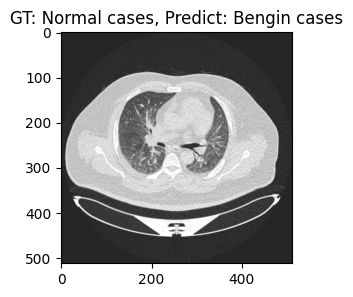

In [40]:
plt.figure(figsize=(3, 3))
plt.title(f'GT: {gt}, Predict: {pt}')
plt.imshow(np.array(img))
plt.show()


0: 512x512 Bengin cases 0.65, Normal cases 0.35, Malignant cases 0.00, 5.1ms
Speed: 1.1ms preprocess, 5.1ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal cases 0.91, Bengin cases 0.09, Malignant cases 0.00, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal cases 0.88, Bengin cases 0.12, Malignant cases 0.00, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Bengin cases 0.56, Normal cases 0.44, Malignant cases 0.00, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal cases 0.91, Bengin cases 0.09, Malignant cases 0.01, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)


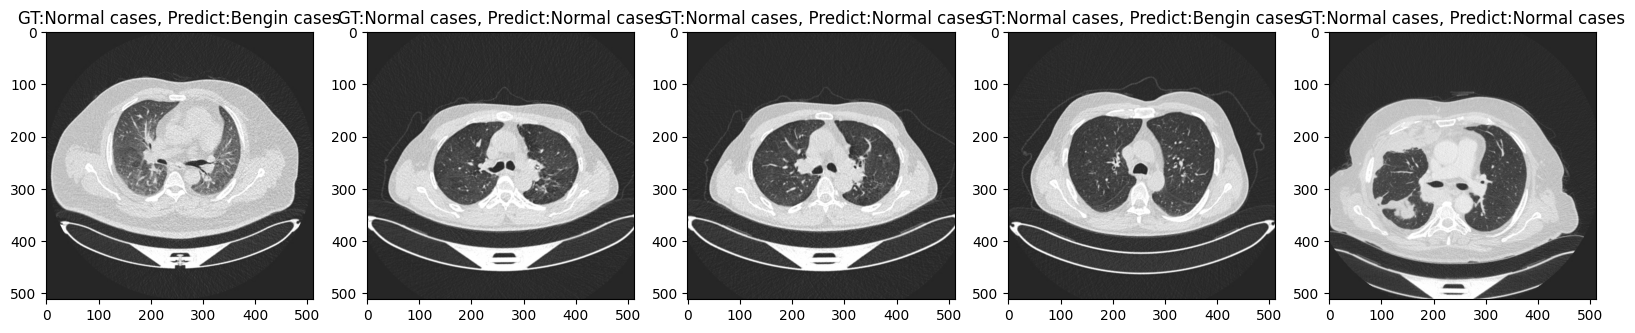

In [41]:
plt.figure(figsize=(20,5))
for idx in range(5):
    img = Image.open(test_file_list[idx]).convert('RGB')
    img_src = test_data_transform(img)
    x_tensor = img_src.unsqueeze(0)
    result = model.predict(x_tensor)[0]
    gt = test_file_list[0].split('/')[-2]
    pt = model.names[torch.argmax(result.probs.data).item()]
    plt.subplot(1, 5, (idx+1))
    plt.title(f'GT:{gt}, Predict:{pt}')
    plt.imshow(img)
plt.show()